# Detection of middle ear events in Tinnitus patients polysomnographic data


In [1]:
#Only once when launching notebook
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')

import matplotlib.pyplot as plt
from time import time
%matplotlib widget
print("Config loaded")

Config loaded


## Load, filter, and prepare data

In [6]:
import mne
from tinnsleep.config import Config
from tinnsleep.data import CreateRaw

filename = Config.bruxisme_files[36]  # load file from config
picks_chan = ['Airflow']           # subset of EMG electrodes
ch_types = ["misc"]

start = time()

raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading
tmin = raw.times[0]                     
tmax = raw.times[-1]
raw  = CreateRaw(raw[picks_chan][0], raw.info["sfreq"], picks_chan, ch_types=ch_types)        # pick channels and load

raw  = raw.filter(0.01, 5., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=['Airflow'])
ch_names = raw.info["ch_names"]
print(f"Data filtered ({time()-start:.2f}s)")
offset = raw.times[0]
print(f"keeping {(raw.times[-1]-raw.times[0])/3600:0.2f} hours of recording out of {(tmax-tmin)/3600:0.2f} hours")

Extracting EDF parameters from /Users/louis/Data/SIOPI/bruxisme/tom_mema.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
250.0


<ipython-input-6-f5339206c79f>:11: RuntimeWarning: 7 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Intensit? lumine', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading


Data filtered (3.39s)
keeping 8.77 hours of recording out of 7.01 hours


## Epoching data

In [4]:
from tinnsleep.data import RawToEpochs_sliding
start = time()
sfreq = raw.info["sfreq"]
window_length = 1                    # in seconds
duration = int(window_length * sfreq)   # in samples
interval = duration                     # no overlapping
epochs = RawToEpochs_sliding(raw, duration=duration, interval=interval)
print(f"Epochs done, shape {epochs.shape} in {time()-start:.2f}s")


Epochs done, shape (31800, 1, 200) in 0.10s


## Classifying epochs and annotate raw

In [7]:
from tinnsleep.classification import AmplitudeThresholding
from tinnsleep.signal import rms
from tinnsleep.data import CleanAnnotations, AnnotateRaw_sliding
from tinnsleep.scoring import classif_to_burst, burst_to_episode, create_list_events
import numpy as np

start = time()
length_adaptive = 60 # in seconds
rel_THR= 3.5
max_duration_between_bursts = 2

#-----------------MEMA processing Foward-backward ---------------------------------------
#Foward
# compute the sum of power over electrodes and samples in each window
pipeline = AmplitudeThresholding(abs_threshold=0., rel_threshold=rel_THR, n_adaptive=length_adaptive)
X        = rms(epochs) # take only valid labels
labels_f   = pipeline.fit_predict(X)


#Backward
#Reversing epochs array
epochs = epochs[::-1]
 # compute the sum of power over electrodes and samples in each window
pipeline = AmplitudeThresholding(abs_threshold=0., rel_threshold=rel_THR, n_adaptive=length_adaptive)
X        = rms(epochs) # take only valid labels
labels   = pipeline.fit_predict(X)
#Reversing labels
labels_b = labels[::-1]


#-----------------MEMA foward-backward merge ---------------------------------------
# Logical OR -- merged backward and foward
labels_fb = np.any(np.c_[labels_f, labels_b], axis=-1)


#-----------------MEMA bursts conversion to episodes ----------------------------------------
OM_burst = classif_to_burst(labels_fb, time_interval=window_length)
OM_ep= burst_to_episode(OM_burst, delim=max_duration_between_bursts, min_burst_joining=0)
li_OM = create_list_events(OM_ep, window_length, window_length* len(labels_fb))

#All episodes as tonic
for i in range(len(li_OM)):
    if li_OM[i]!=0:
        li_OM[i]=True
    else:
        li_OM[i] = False


print(f"bursts count: {np.sum(li_OM)}/{len(li_OM)} ({np.sum(li_OM) / len(li_OM) * 100:.2f}%)")
print(f"bursts time: {np.sum(li_OM) * window_length} seconds")
print(f"Classification done in {time()-start:.2f}s")

dict_annotations = {1: "MEA"}
annotations = []
for k, label in enumerate(li_OM):
    if label > 0:
        annotations.append(dict(
            onset=k*interval/sfreq,
            duration=duration/sfreq,
            description=dict_annotations[label],
            orig_time=offset
        )
            
        )
raw = CleanAnnotations(raw)
raw = AnnotateRaw_sliding(raw, li_OM, 
                dict_annotations=dict_annotations, duration=duration, interval=interval)
print("Raw annotated")

bursts count: 526/31800 (1.65%)
bursts time: 526 seconds
Classification done in 5.73s
Raw annotated


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

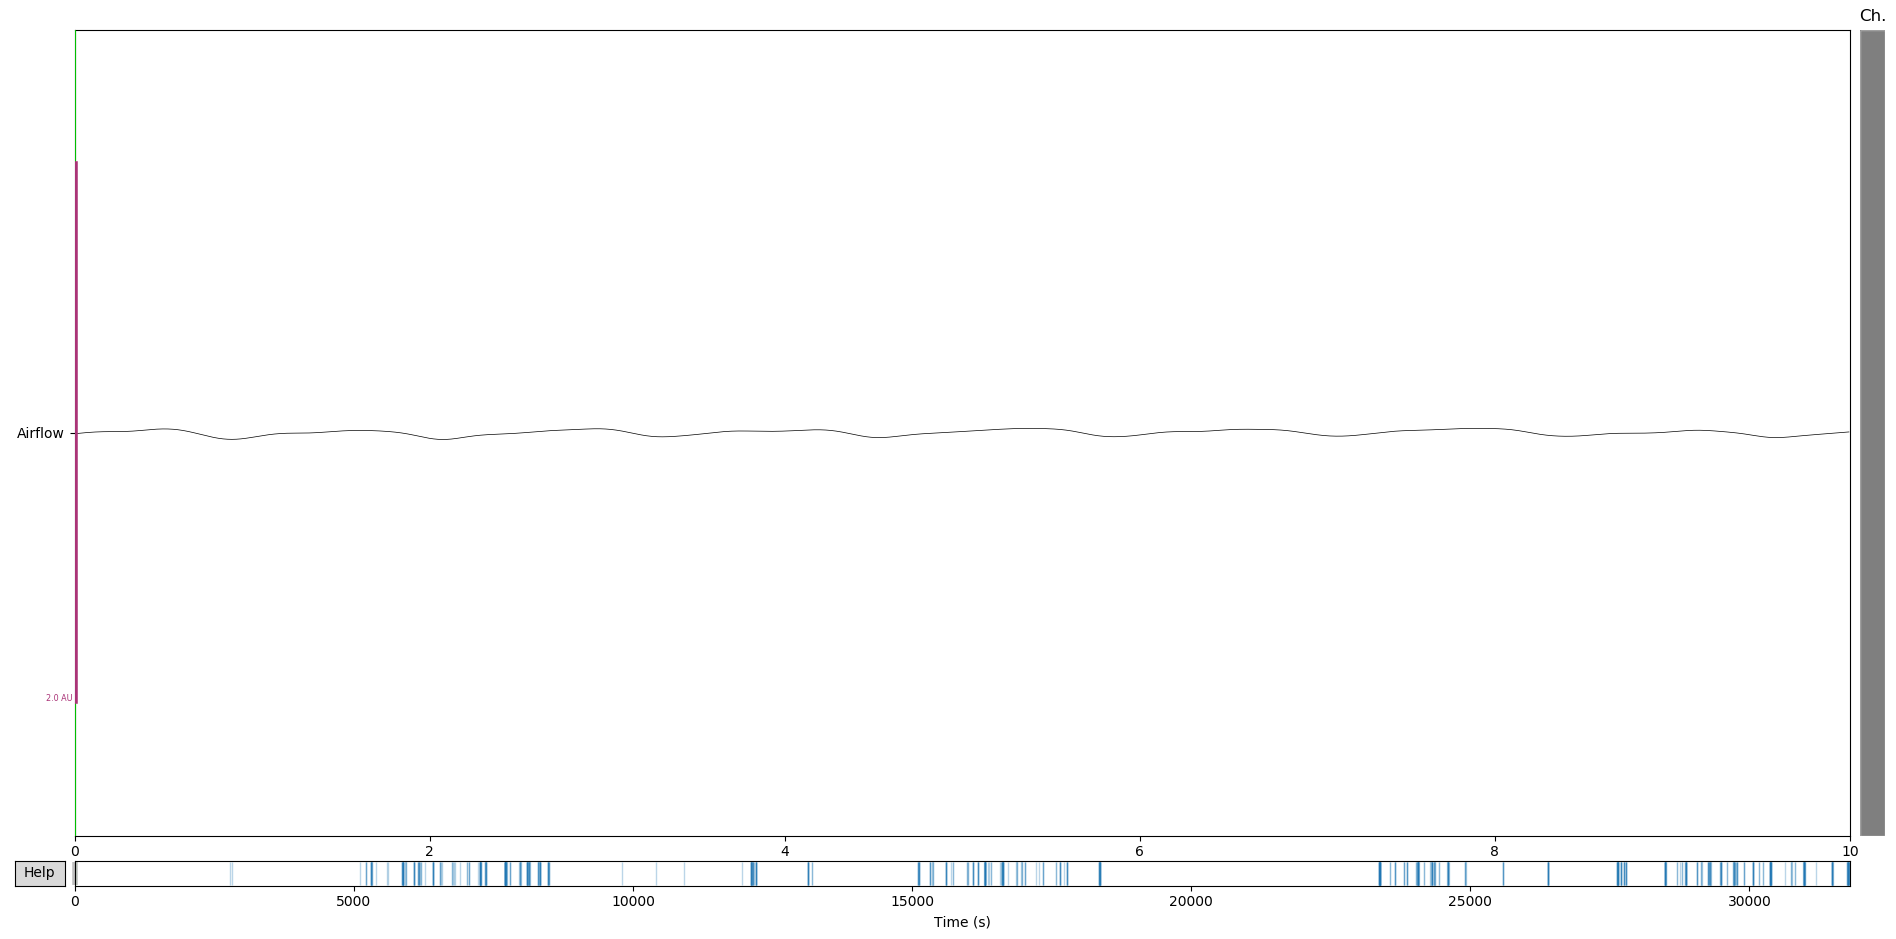

In [6]:
%matplotlib qt
scalings = dict(misc=1)
raw.plot(scalings = scalings)